In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead
import shap
from shap.utils import cal_conditional_logits
import scipy as sp
import nlp
import torch
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option("max_rows", None)
from simalign import SentenceAligner
from typing import List, Text, Tuple
import string

In [2]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")
model = AutoModelWithLMHead.from_pretrained("Helsinki-NLP/opus-mt-en-es").cuda()

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.


In [3]:
# This function creates additional keyword arguments which is passed onto the model function
def gen_kwargs(x):
    inputs = tokenizer([x], max_length=512, return_tensors='pt',min_length=0,truncation=True)
    input_ids=inputs['input_ids'].cuda()
    with torch.no_grad():
        # generate input ids for output translation which we aim to explain
        out=model.generate(input_ids)
    decoder_inputs=out[:,:-1]
    output_names = tokenizer.convert_ids_to_tokens(out[0,1:-1])
    del out
    return {'decoder_inputs':decoder_inputs,'input_ids':input_ids,'output_names':output_names}

In [4]:
# This function defines the additional arguments passed onto the model function required inorder to get conditional logits corresponding to the original input sentence translation
def f_kwargs(x):
    kwargs = gen_kwargs(x)
    return kwargs

In [5]:
def f(x_batch,**kwargs):
    output_batch=[]
    # Extract decoder inputs for which we want to generate conditional logits
    decoder_inputs=kwargs['decoder_inputs']
    for i,x in enumerate(x_batch):
        inputs = tokenizer([x], max_length=1024, return_tensors='pt',truncation=True)
        input_ids=inputs['input_ids']
        conditional_logits = cal_conditional_logits(model,input_ids,decoder_inputs)
        output_batch.append(conditional_logits)
    return np.array(output_batch)

In [6]:
# Example function which returns a summary ids 
def example_summarize(x,model,tokenizer):
    print(f"Input: {x}")
    inputs = tokenizer([x], max_length=512, return_tensors='pt',truncation=True)
    input_ids=inputs['input_ids'].cuda()
    summary_ids = model.generate(input_ids).detach().cpu().numpy()
    del input_ids
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    print(f"summary: {summary[0]}")
    return summary_ids[0,1:-1]

In [7]:
s="In this picture, there are four persons: my father, my mother, my brother and my sister."
ids=example_summarize(s,model,tokenizer)

Input: In this picture, there are four persons: my father, my mother, my brother and my sister.
summary: En este cuadro, hay cuatro personas: mi padre, mi madre, mi hermano y mi hermana.


In [8]:
explainer = shap.Explainer(f,tokenizer,model_kwargs=f_kwargs)

explainers.Partition is still in an alpha state, so use with caution...


In [9]:
shap_values = explainer([s])

Keyword arguments {'min_length': 0} not recognized.


In [11]:
for i,id in enumerate(ids):
    print(f'Output token: {tokenizer.convert_ids_to_tokens(int(id))}')
    shap.plots.text(shap_values[0][:,i])

Output token: ▁En


Output token: ▁este


Output token: ▁cuadro


Output token: ,


Output token: ▁hay


Output token: ▁cuatro


Output token: ▁personas


Output token: :


Output token: ▁mi


Output token: ▁padre


Output token: ,


Output token: ▁mi


Output token: ▁madre


Output token: ,


Output token: ▁mi


Output token: ▁hermano


Output token: ▁y


Output token: ▁mi


Output token: ▁hermana


Output token: .


### SimAlign

In [12]:
myaligner = SentenceAligner(model="bert", token_type="word", matching_methods="mai", layer=12, return_dict=True)

2020-10-20 14:42:54,886 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased
INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased


In [13]:
def reconstruct_alignment_matrix(matchings: Text, n: int, m: int):
    alignment_matrix = np.zeros((n, m))
    for i,j in matchings:
        alignment_matrix[i, j] = 1
    return alignment_matrix

In [14]:
def clean_text(words):
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words if w.translate(table)!=""]
    return stripped

In [15]:
def get_sim_align_scores(src_sentence,trg_sentence):
    alignment_dict = myaligner.get_word_aligns(src_sentence, trg_sentence)
    n,m=alignment_dict["similarity_matrix"].shape
    alignment_matrix = reconstruct_alignment_matrix(alignment_dict["alignments"]["mwmf"],n,m)
    alignment_scores = alignment_dict["similarity_matrix"]*alignment_matrix
    axis_aligned_alignment_score = alignment_scores.sum(0)
    no_of_matchings = alignment_scores.astype(bool).sum(0)
    sim_align_scores = [axis_aligned_alignment_score[i]/no_of_matchings[i] if no_of_matchings[i]>0 else 0 for i in range(len(axis_aligned_alignment_score))]
    print(f'Source sentence translation: {src_sentence}')
    if isinstance(trg_sentence,str):
        trg_sentence = trg_sentence.split()
    mlp.rcParams['figure.figsize']=(10,5)
    plt.bar(trg_sentence,sim_align_scores)
    plt.xticks(rotation=90)
    plt.show()
    return sim_align_scores  

In [16]:
def gen_kwargs_sim_align(x):
    inputs = tokenizer([x], max_length=512, return_tensors='pt',truncation=True)
    input_ids=inputs['input_ids'].cuda()
    summary_ids = model.generate(input_ids).detach().cpu().numpy()
    del input_ids
    summary=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0]
    summary = clean_text(summary.split())
    output_names = summary
    return {'target_sentence':summary,'output_names':output_names}

In [17]:
def f_kwargs_sim_align(x):
    kwargs = gen_kwargs_sim_align(x)
    return kwargs

In [18]:
def f_sim_align(x_batch,**kwargs):
    output_batch=[]
    # Extract decoder inputs for which we want to generate conditional logits
    target_sentence=kwargs['target_sentence']
    for i,x in enumerate(x_batch):
        print(f'Source sentence: {x}')
        inputs = tokenizer([x], max_length=512, return_tensors='pt',truncation=True)
        input_ids=inputs['input_ids'].cuda()
        output_ids = model.generate(input_ids).detach().cpu().numpy()
        del input_ids
        source_sentence=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in output_ids][0]
        source_sentence = clean_text(source_sentence.split())
        sim_align_scores = get_sim_align_scores(source_sentence,target_sentence)
        output_batch.append(sim_align_scores)
    return np.array(output_batch)

In [19]:
explainer = shap.Explainer(f_sim_align,tokenizer,model_kwargs=f_kwargs_sim_align)

explainers.Partition is still in an alpha state, so use with caution...


Source sentence: 


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['No', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']


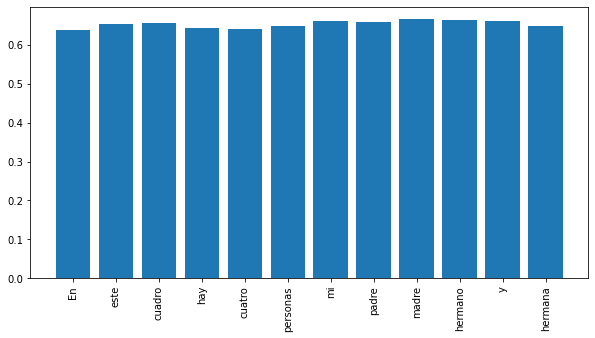

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


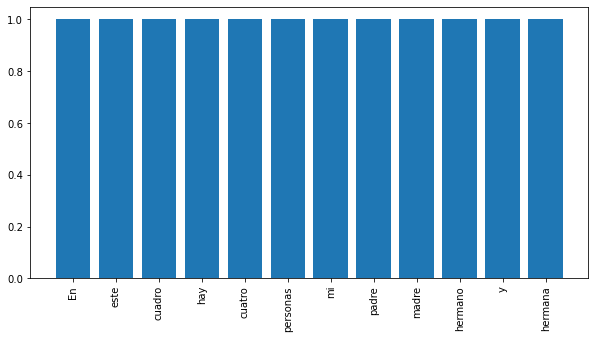

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father,


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre']


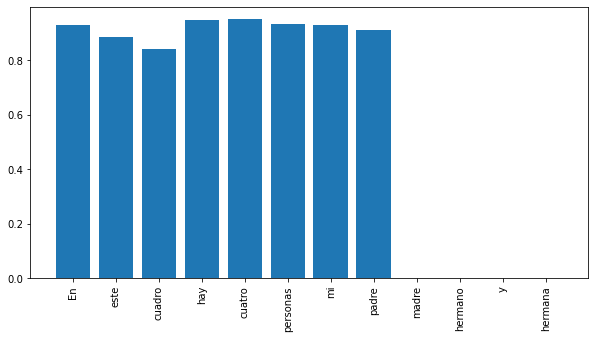

Source sentence: my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


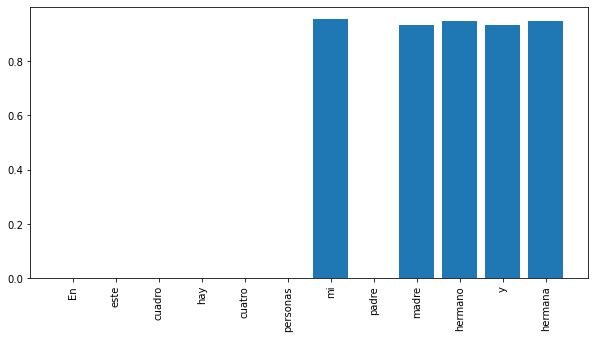

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


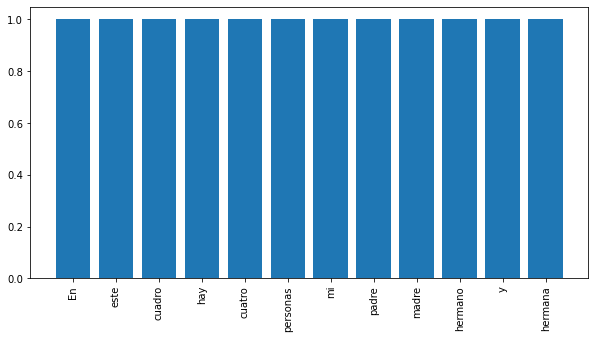

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father,


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre']


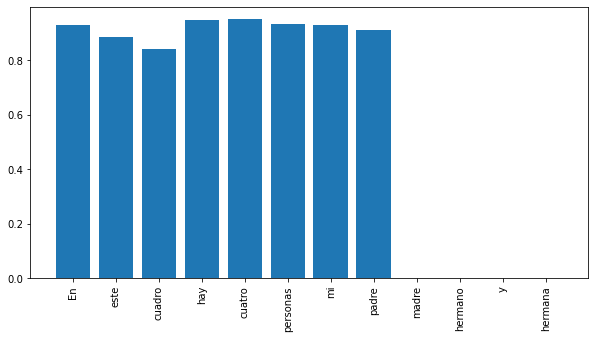

Source sentence: In this▁picture, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


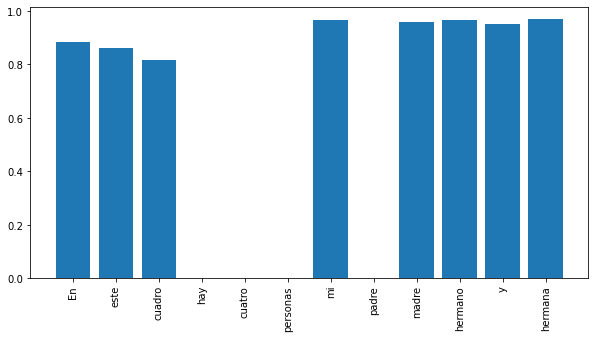

Source sentence: ▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['Hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


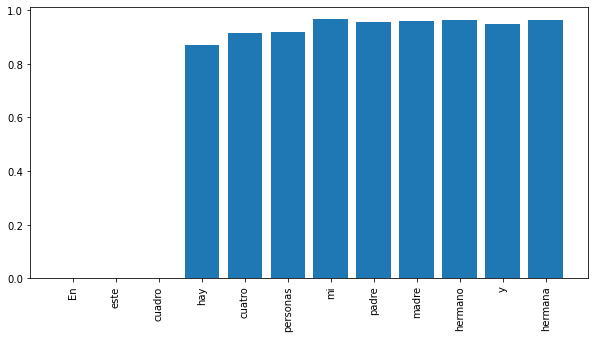

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother,


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre']


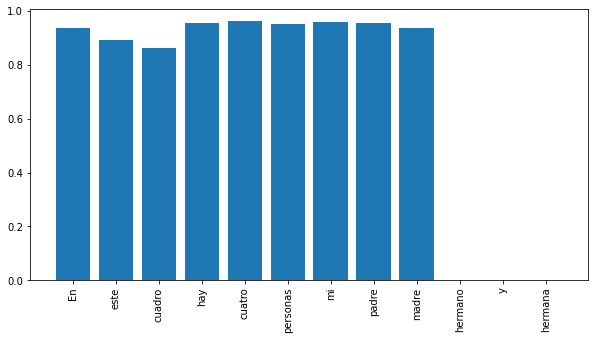

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'hermano', 'y', 'mi', 'hermana']


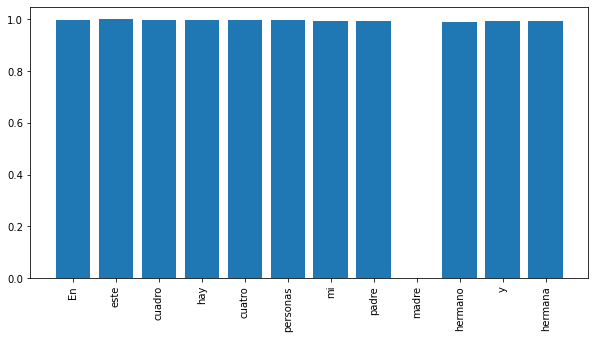

Source sentence: In this▁picture▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


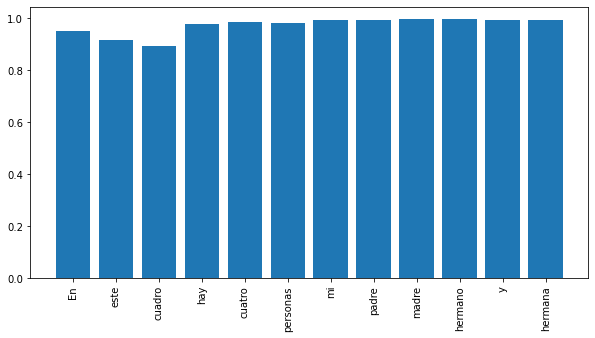

Source sentence: ,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


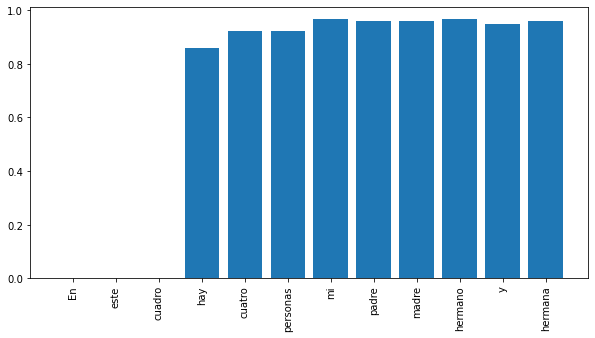

Source sentence: In this▁picture,▁there▁are▁four▁persons my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


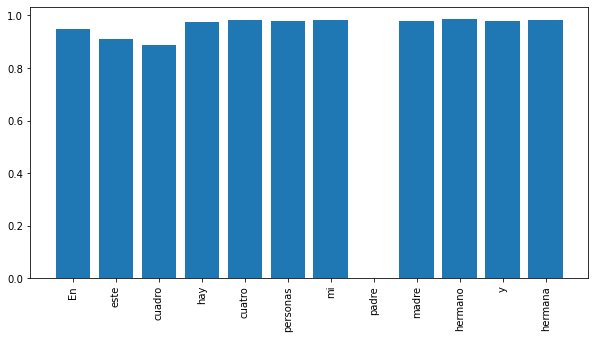

Source sentence: In this▁picture,: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


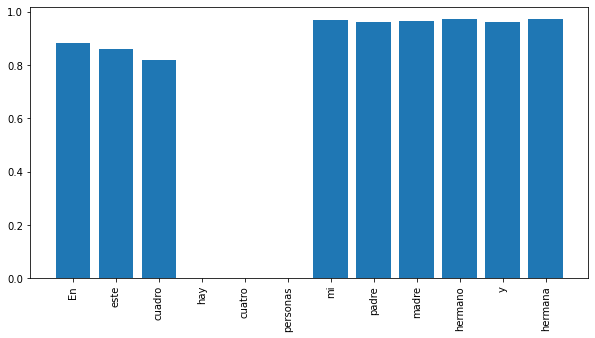

Source sentence: In this,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


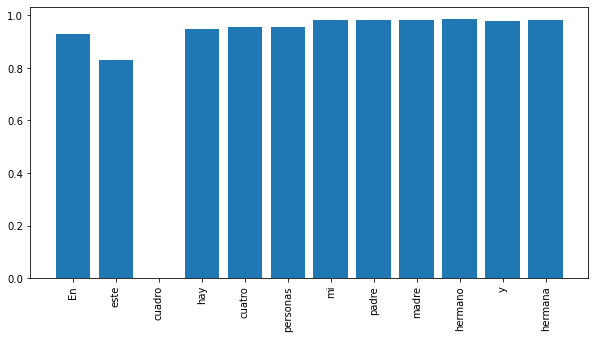

Source sentence: ▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['picture', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


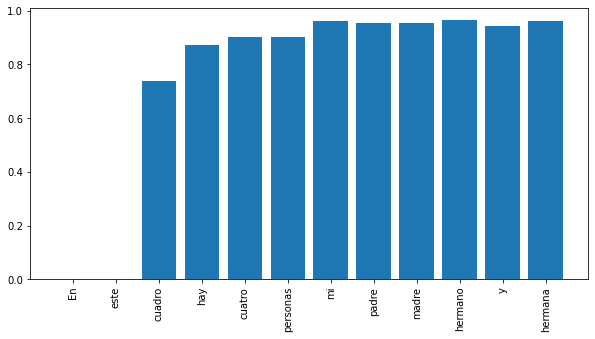

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y']


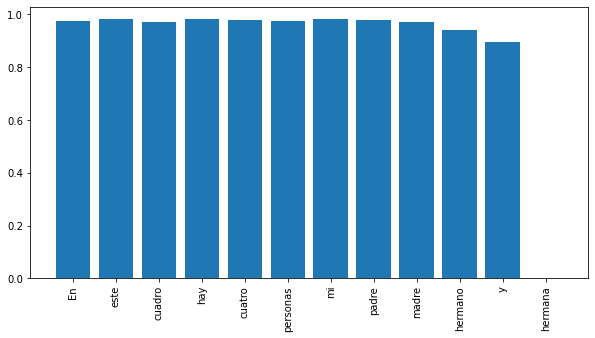

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermana']


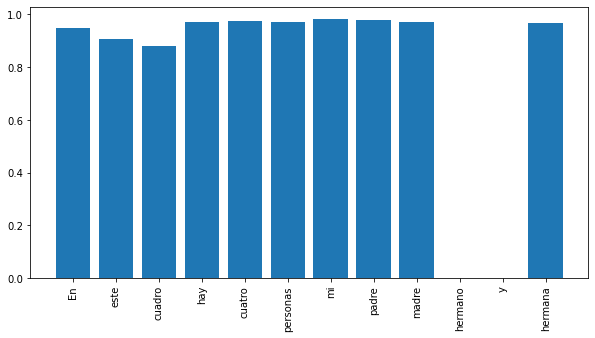

Source sentence: In this▁picture,▁there▁are: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'están', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


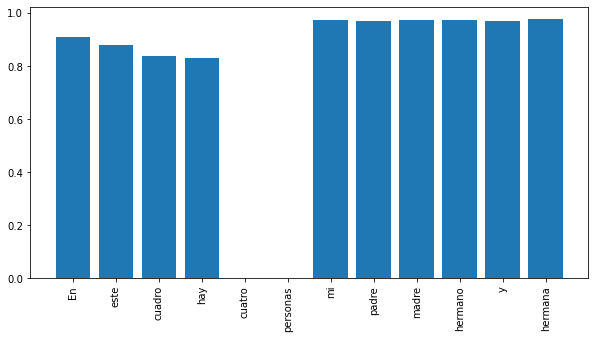

Source sentence: In this▁picture,▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


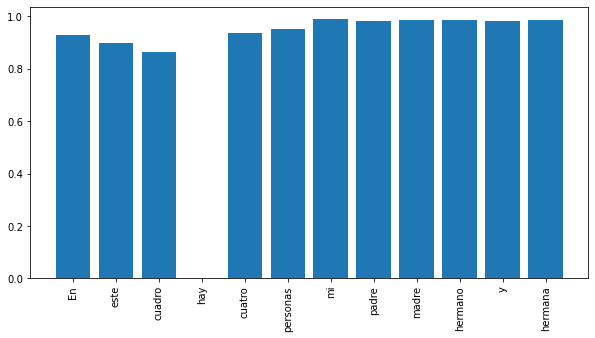

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


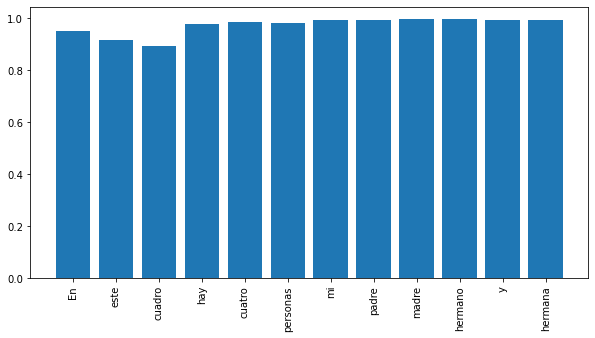

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y']


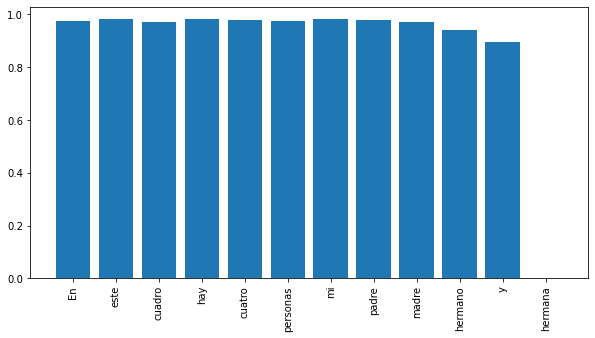

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'mi', 'hermana']


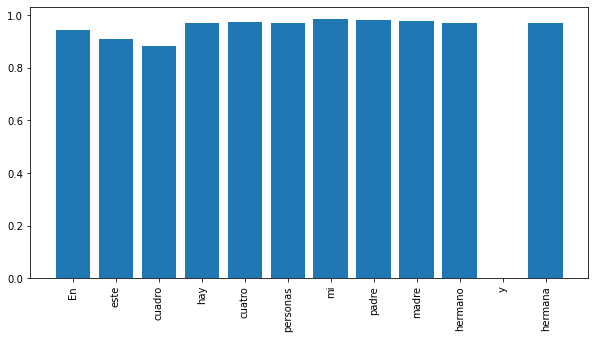

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'y', 'mi', 'hermana']


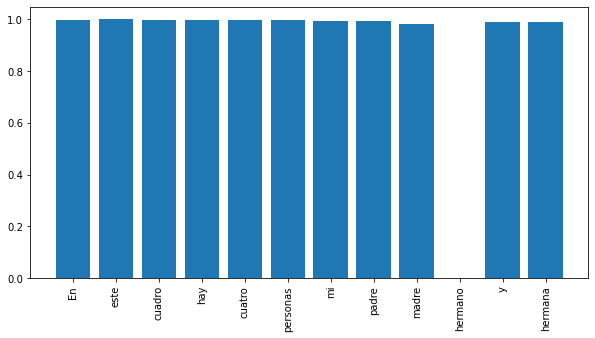

Source sentence: In this▁picture,▁there▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


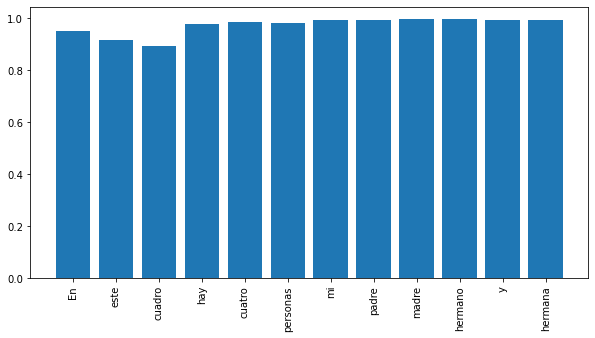

Source sentence: In this▁picture,▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


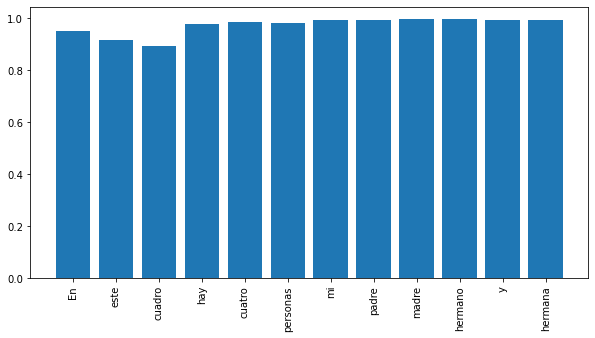

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi']


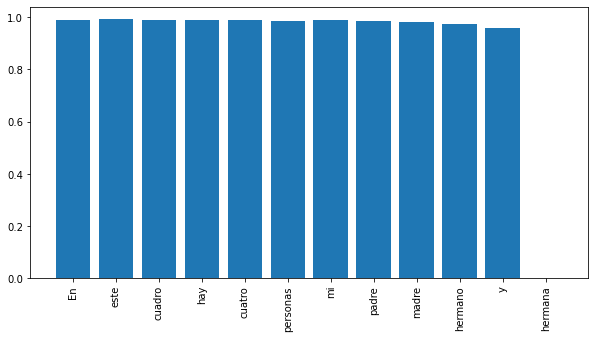

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


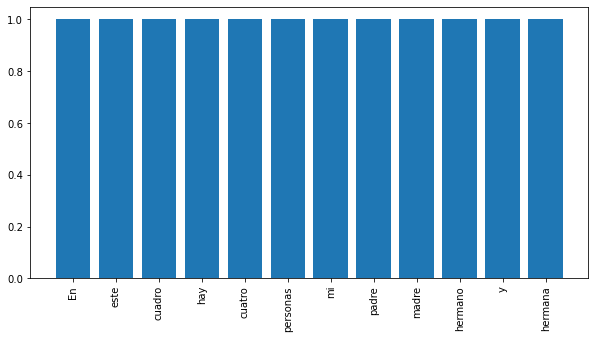

Source sentence: In▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'la', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


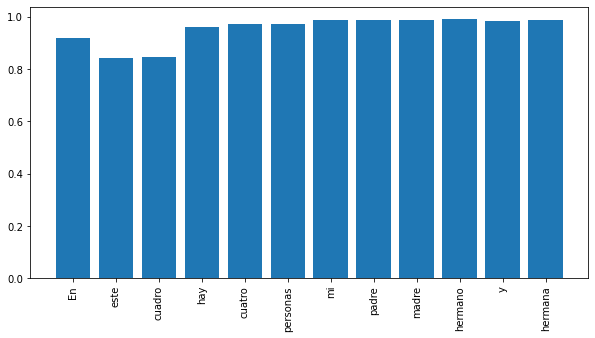

Source sentence: this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['Esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


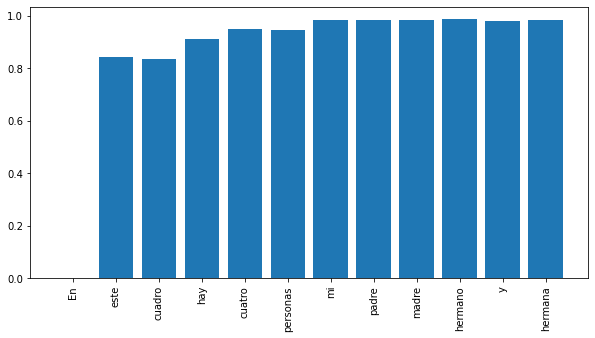

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother, my and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'y', 'mi', 'hermana']


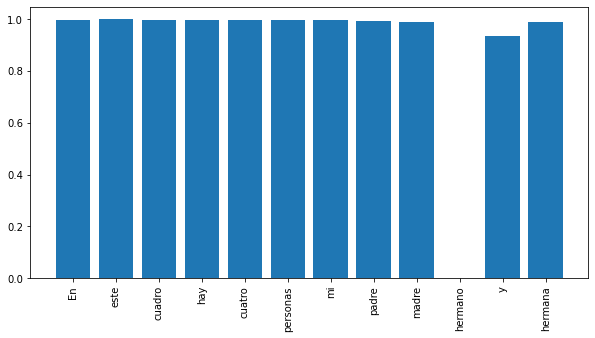

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother,▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


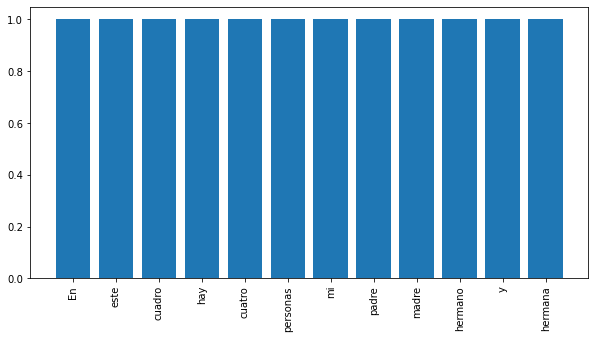

Source sentence: In this▁picture,▁there▁are▁four: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


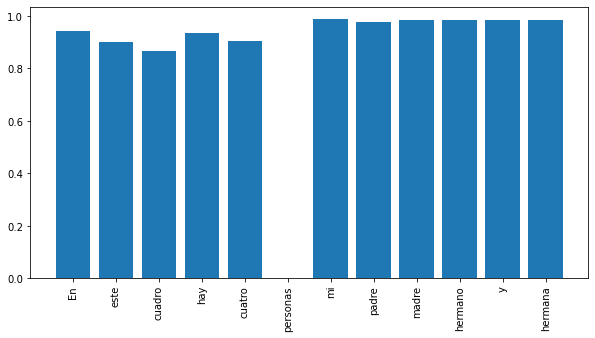

Source sentence: In this▁picture,▁there▁are▁persons: my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


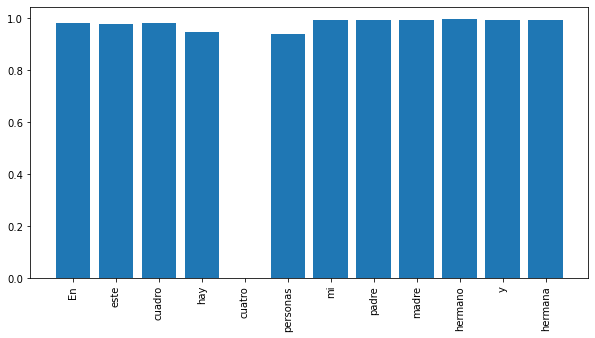

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my▁mother my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


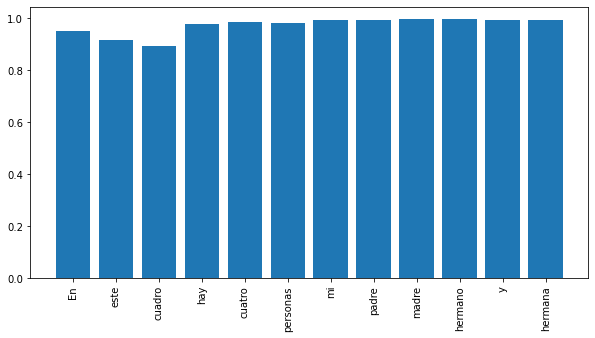

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father,, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'hermano', 'y', 'mi', 'hermana']


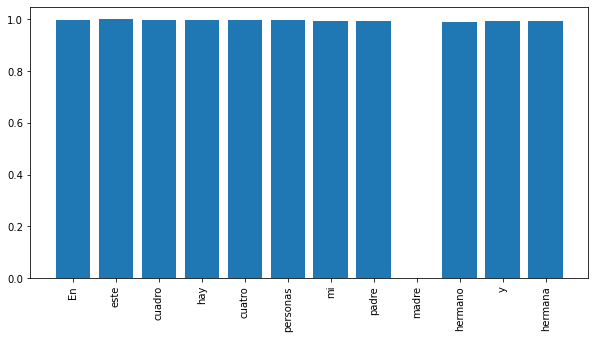

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


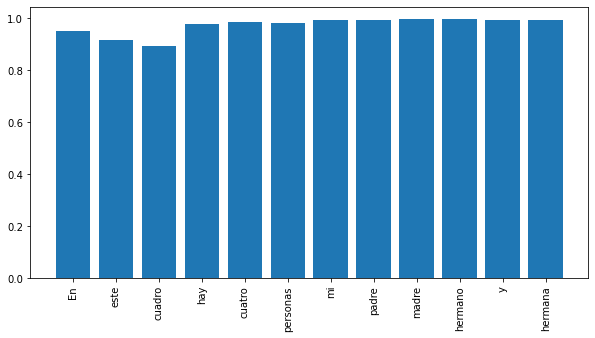

Source sentence: In this▁picture,▁there▁are▁four▁persons, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


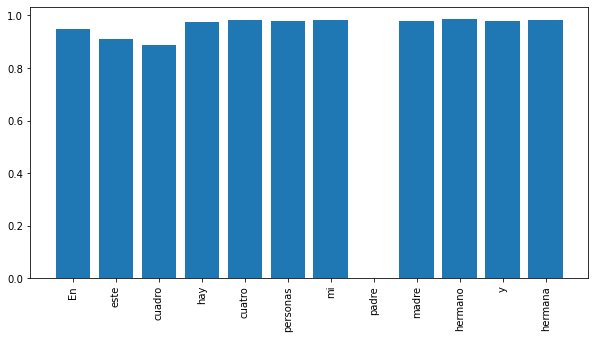

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father, my, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'hermano', 'y', 'mi', 'hermana']


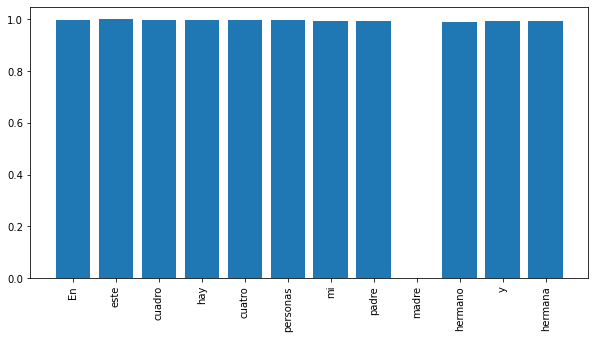

Source sentence: In this▁picture,▁there▁are▁four▁persons: my▁father,▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


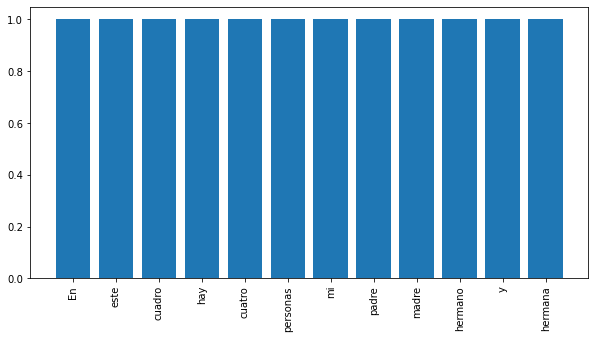

Source sentence: In this▁picture,▁there▁are▁four▁persons: my, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


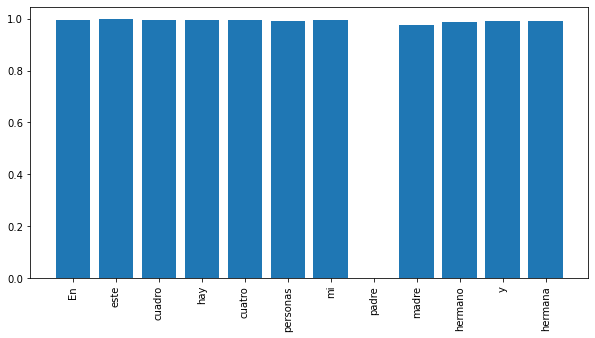

Source sentence: In this▁picture,▁there▁are▁four▁persons▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


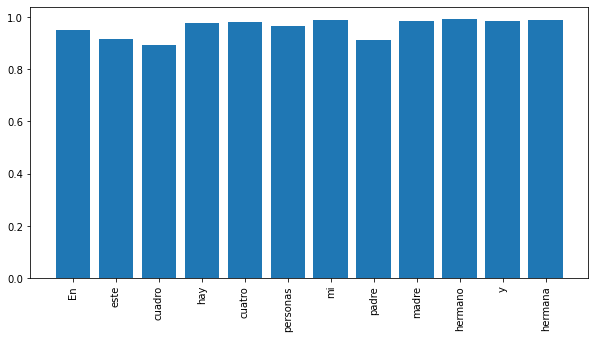

Source sentence: In this▁picture,▁there▁are▁four▁persons:▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


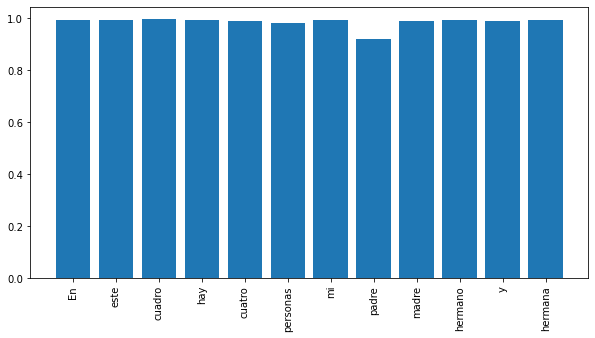

Source sentence: In this▁picture,▁there▁are▁four▁persons my▁father, my▁mother, my▁brother and my▁sister.


`is_pretokenized` is deprecated and will be removed in a future version, use `is_split_into_words` instead.


Source sentence translation: ['En', 'esta', 'foto', 'hay', 'cuatro', 'personas', 'mi', 'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']


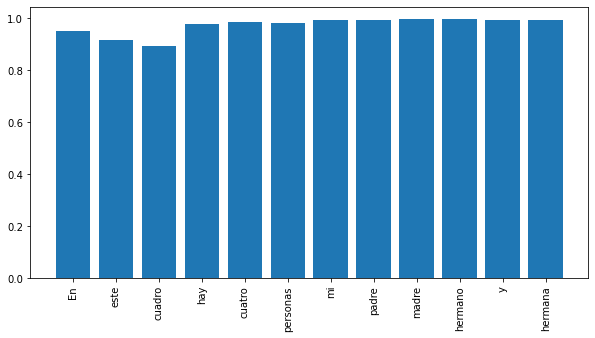

Partition explainer: 2it [00:40, 20.05s/it]                                                                            


In [20]:
shap_values_sim_align = explainer([s])

In [21]:
shap_values_sim_align.shape

(1, 22, 15)

In [22]:
shap_values_sim_align.output_names

array([['En', 'este', 'cuadro', 'hay', 'cuatro', 'personas', 'mi',
        'padre', 'mi', 'madre', 'mi', 'hermano', 'y', 'mi', 'hermana']],
      dtype='<U8')

In [23]:
for i,id in enumerate(shap_values_sim_align.output_names[0]):
    print(f'Output token: {id}')
    shap.plots.text(shap_values_sim_align[0][:,i])

Output token: En


Output token: este


Output token: cuadro


Output token: hay


Output token: cuatro


Output token: personas


Output token: mi


Output token: padre


Output token: mi


Output token: madre


Output token: mi


Output token: hermano


Output token: y


Output token: mi


Output token: hermana
